In [3]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy,categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
# from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
# from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf 
import keras,os
from keras.layers import MaxPool2D 
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../input"))

['shai-level-2-training']


In [4]:
# Define path to the data directory
data_dir = Path('../input/shai-level-2-training')
# '/kaggle/input/shai-level-2-training'
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'normal'
virus_cases_dir = train_dir / 'virus'
covid_cases_dir = train_dir / 'covid'

# Get the list of all the images
# jpeg, png, jpg
covid_cases = covid_cases_dir.glob('*g' )
normal_cases = normal_cases_dir.glob('*g')
virus_cases = virus_cases_dir.glob('*g')
train = {}
for i in ['covid', 'normal', 'virus']:
    train[i] = glob.glob("../input/shai-level-2-training/train/{}/*g".format(i))
    
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 0))

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,1))

# Go through all the virus cases. The label for these cases will be 1
for img in virus_cases:
    train_data.append((img, 2))
    

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,../input/shai-level-2-training/train/covid/535...,0
1,../input/shai-level-2-training/train/virus/413...,2
2,../input/shai-level-2-training/train/normal/37...,1
3,../input/shai-level-2-training/train/normal/64...,1
4,../input/shai-level-2-training/train/virus/301...,2


1    468
2    433
0    295
Name: label, dtype: int64


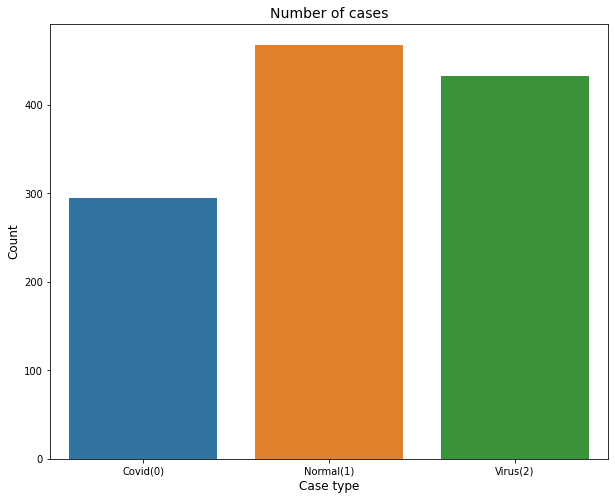

In [6]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Covid(0)','Normal(1)','Virus(2)'])
plt.show()

In [7]:
print(len(train_data))

1196


In [8]:
train = pd.read_csv("../input/shai-level-2-training/train.csv")
train.head()

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal


In [9]:
for i in range(train.shape[0]):
    train.loc[i,'Image'] = "../input/shai-level-2-training/train/" + train.loc[i,'Label'] + "/" + train.loc[i,'Image']

In [10]:
from sklearn.preprocessing import LabelEncoder
Ln=LabelEncoder().fit(train['Label'])

In [11]:
from skimage.io import imread

for i in range(train.shape[0]):
    img = imread(train.loc[i,'Image'])
    print(img.shape)
    if i == 20 :
        break

(909, 1280)
(559, 883, 3)
(1642, 1840)
(850, 1114)
(2411, 2318)
(1546, 1774)
(720, 1240)
(1537, 1666)
(1400, 1676)
(480, 640, 3)
(531, 877, 3)
(1472, 1770)
(1120, 1568)
(1104, 1328)
(630, 1076, 3)
(1577, 2022)
(1056, 1392)
(1314, 1850)
(1692, 1882)
(1106, 1492)
(1852, 2169, 4)


In [12]:
covid_samples = (train_data[train_data['label']==0]['image'].iloc[:10]).tolist()
normal_samples = (train_data[train_data['label']==1]['image'].iloc[:10]).tolist()
virus_samples = (train_data[train_data['label']==2]['image'].iloc[:10]).tolist()

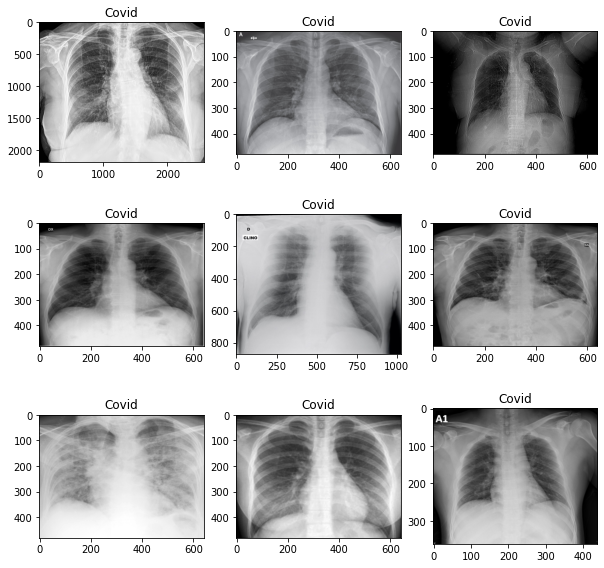

In [13]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(covid_samples[i]),cmap='gray')
    plt.title("Covid")
plt.show()

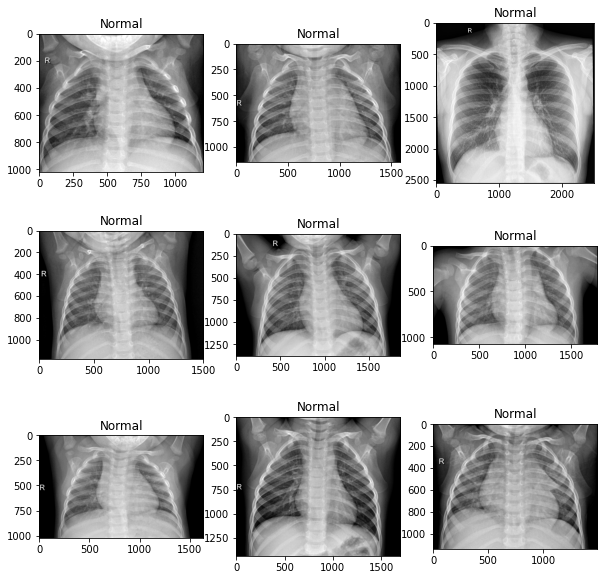

In [14]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(normal_samples[i]),cmap='gray')
    plt.title("Normal")
plt.show()

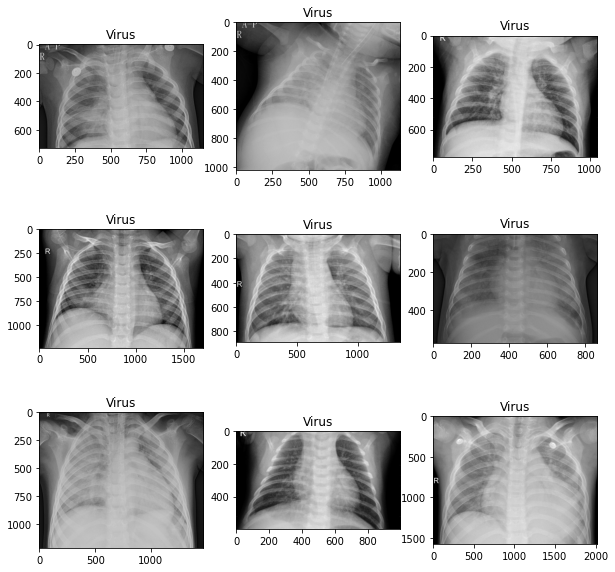

In [15]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(virus_samples[i]),cmap='gray')
    plt.title("Virus")
plt.show()

# It is clear that images are at different sizes.

In [16]:
train_data.shape

(1196, 2)

In [17]:

image_size = 224 
BATCH_SIZE = 32 
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE


train_datagen = ImageDataGenerator(
        rescale=1./255,
         validation_split=0.2,
         shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=15,
        fill_mode="nearest")



training_set = train_datagen.flow_from_directory(train_dir,
                                                 subset='training',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

validation_set = train_datagen.flow_from_directory(train_dir,
    subset='validation',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True)



Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.


In [18]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (32, 224, 224, 3)
sample train label 
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [19]:
print("validation batch ", validation_set .__getitem__(0)[0].shape)
print("sample validation label \n", validation_set .__getitem__(0)[1][:5])

validation batch  (32, 224, 224, 3)
sample validation label 
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [20]:
training_set.class_indices

{'covid': 0, 'normal': 1, 'virus': 2}

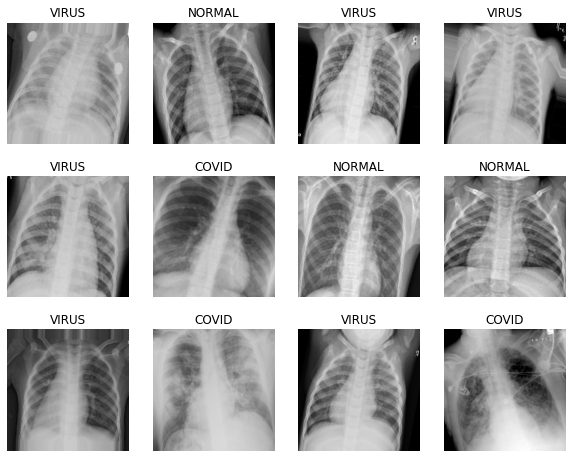

In [21]:
labels = ['COVID', 'NORMAL', 'VIRUS']

sample_data = training_set.__getitem__(0)[0] 
sample_label = training_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [22]:
# Building the Convolutional Neural Network with Keras
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape =(224,224,3)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid'))

2022-10-01 00:52:17.501748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 00:52:17.597636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 00:52:17.598555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 00:52:17.600351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [ ]:
#MODEL PREPARATION 
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
#     x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model
model =  build_model()

In [23]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.0001, patience=3, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [24]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
    layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model_densenet.summary()

74850304/74836368 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [27]:
from keras.backend import clear_session
clear_session()

In [28]:
history_densenet =model_densenet.fit_generator(training_set,epochs=20,validation_data=validation_set,callbacks=[lr_reduce, es_callback])

Epoch 1/20
30/30 [==============================] - 47s 2s/step - loss: 0.5239 - accuracy: 0.7871 - val_loss: 0.3604 - val_accuracy: 0.8824
Epoch 2/20
30/30 [==============================] - 32s 1s/step - loss: 0.3485 - accuracy: 0.8716 - val_loss: 0.2443 - val_accuracy: 0.9118
Epoch 3/20
30/30 [==============================] - 31s 1s/step - loss: 0.2963 - accuracy: 0.8946 - val_loss: 0.2133 - val_accuracy: 0.9412
Epoch 4/20
30/30 [==============================] - 31s 1s/step - loss: 0.2469 - accuracy: 0.9081 - val_loss: 0.2153 - val_accuracy: 0.9328
Epoch 5/20
30/30 [==============================] - 31s 1s/step - loss: 0.2418 - accuracy: 0.9144 - val_loss: 0.1771 - val_accuracy: 0.9328
Epoch 6/20
30/30 [==============================] - 31s 1s/step - loss: 0.2089 - accuracy: 0.9259 - val_loss: 0.1420 - val_accuracy: 0.9454
Epoch 7/20
30/30 [==============================] - 31s 1s/step - loss: 0.2188 - accuracy: 0.9238 - val_loss: 0.1835 - val_accuracy: 0.9412
Epoch 8/20
30/30 [==

In [ ]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet_50.trainable=False

In [ ]:
inputs = keras.Input(shape=(image_size, image_size,3))
x = resnet_50(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)
model_resnet = keras.Model(inputs=inputs, outputs=outputs, name="my_model")

model_resnet.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')

model_resnetsummary()

In [ ]:
history_resnet =model_resnet.fit_generator(training_set,epochs=7,validation_data=validation_set)

In [ ]:
import tensorflow as tf 
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
    layer.trainable = False

In [32]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

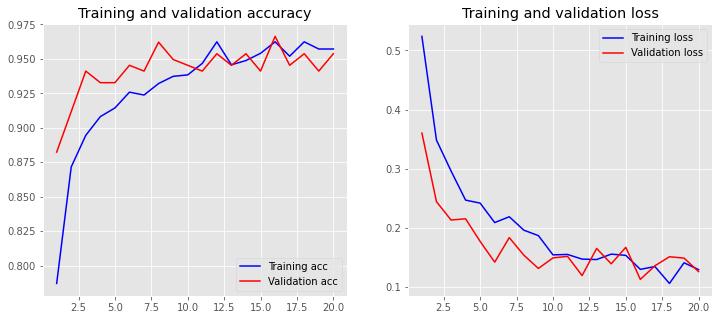

In [38]:
plot_history(history_densenet)

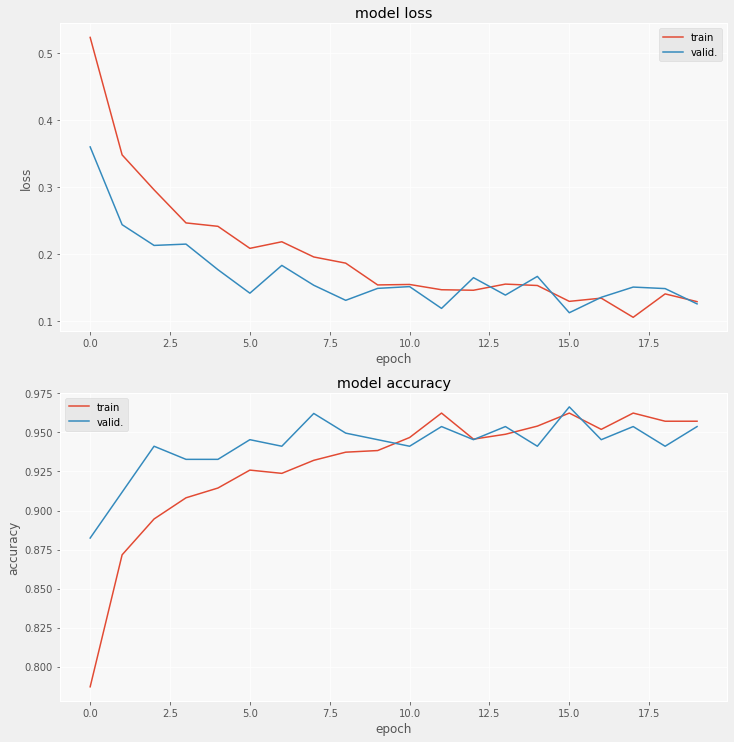

In [33]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

In [34]:
df=pd.read_csv('../input/shai-level-2-training/sample_submission.csv')

In [35]:
for i in os.listdir('../input/shai-level-2-training/test'):
    x = cv2.imread('../input/shai-level-2-training/test/'+i, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (224, 224))
    x=x/255
    x=np.expand_dims(x,axis=0)
    predict=model_densenet.predict(x)
    df['Label'][df['Image']==i]=str(Ln.inverse_transform([np.argmax(predict)])[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df

,Image,Label
0,402124007.png,covid
1,20328626.jpeg,normal
2,21235419.jpeg,normal
3,188238579.png,covid
4,266831585.jpeg,normal
...,...,...
508,232629532.jpeg,virus
509,256499192.jpeg,virus
510,223507116.jpeg,normal
511,178434487.jpeg,covid


In [37]:
df.to_csv('wesam.csv',index=False)